# Task:
1. Extract the budget, revenue, and MPAA Rating (G/PG/PG-13/R), which is also called "Certification" and extract and save the results for movies that meet all of the criteria established in part 1 of the project (You should already have a filtered dataframe saved from part one as a csv.gz file)
    - Do the above for movies that started in 2000 and 2001
    - Each year should be saved as a separate .csv.gz file


2. In order to ensure your function for extracting movie data from TMDB is working, test your function on these 2 movie ids: tt0848228 ("The Avengers") and tt0332280 ("The Notebook"). Make sure that your function runs without error and that it returns the correct movie's data for both test ids.


3. Load in your csv.gz's of results for each year extracted.
    - Concatenate the data into 1 dataframe for the remainder of the analysis.
    

4. Once you have your data from the API, they would like you to perform some light EDA to show:
    - How many movies had at least some valid financial information (values > 0 for budget OR revenue)?
        - Please exclude any movies with 0's for budget AND revenue from the remaining visualizations.
    - How many movies are there in each of the certification categories (G/PG/PG-13/R)?
    - What is the average revenue per certification category?
    - What is the average budget per certification category?

In [23]:
# Imports
import pandas as pd
import numpy as np
import os, time, json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
# API imports
import json
with open('C:\\Users\\Chris Palisoc\\.secret\\tmdb_api.json', 'r') as f:
    login = json.load(f)
login.keys()
import tmdbsimple as tmdb
tmdb.API_KEY = login['api-key']

## Designate a Folder

In [2]:
# Save API call data in current 'Data' folder
FOLDER="Data\\"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['title_akas.csv.gz', 'title_basics.csv.gz', 'title_ratings.csv.gz']

## Define Functions

In [3]:
# Function that appends a list of records (new_data) to a json file (filename).
def write_json(new_data, filename): 
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

In [4]:
# Function that returns movie certification (rating)
def get_movie_with_rating(movie_id):
    # get movie using curent id
    movie = tmdb.Movies(movie_id)
    # save the .info .releases dictionaries
    info = movie.info()
    releases = movie.releases()
    # loop thru countries in releases
    for c in releases['countries']:
        # if countries = US, save the certification key in info
        if c['iso_3166_1']=='US':
            info['certification'] = c['certification']
    
    return info

## Outer and Inner Loops

In [5]:
# Load title_basics data
basics = pd.read_csv('Data\\title_basics.csv.gz')

In [6]:
# Create list of the years that we are extracting for (2000 & 2001)
YEARS_TO_GET = [2000 , 2001]
# Create an 'errors' list to save the id's and errors for movies that cause an error
errors = []

In [8]:
# Start outer loop
# Set up progress bar
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    # Define JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    # if file exists:
    file_exists = os.path.isfile(JSON_FILE)
    # if file does not exist:
    if file_exists == False:
    #save an emmpty dict w/'imdb_id' to new json file
        with open(JSON_FILE, 'w') as f:
            json.dump([{'imdb_id':0}], f)

    # Define/filter the IDs to call
    # save new year as the current df
    df = basics.loc[basics['startYear']==YEAR].copy()
    # save movie IDs to list
    movie_ids = df['tconst'].copy()

    # Load existing data from json into 'previous_df' dataframe
    previous_df = pd.read_json(JSON_FILE)

    # filter out any IDs that are already in JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]

## Inner loop

# Get index and movie id from list
# Inner loop
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                 desc=f'Movies from {YEAR}',
                                 position=1,
                                 leave=True):
        try:
            # Retrieve data for the movie id
            temp = get_movie_with_rating(movie_id)
            # Append/extend results to existing file using write_json function
            write_json(temp, JSON_FILE)
            # add 20 ms sleep to prevent overwhleming server
            time.sleep(0.02)

        except Exception as e:
            errors.append([movie_id, e])
            
    # Save Years extracted to a smaller csv.gz file
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip",
                        index=False)

YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

Movies from 2000:   0%|          | 0/2738 [00:00<?, ?it/s]

Movies from 2001:   0%|          | 0/2864 [00:00<?, ?it/s]

In [9]:
# Print a message displaying number of errors and the movie IDs
print(f'- Total errors: {len(errors)}')

- Total errors: 1101


# Test Movie Certification Function

In [10]:
# Use movie IDs 'tt0848228' and 'tt0332280' to ensure get_movie_with_rating works
get_movie_with_rating('tt0848228')

{'adult': False,
 'backdrop_path': '/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg',
 'belongs_to_collection': {'id': 86311,
  'name': 'The Avengers Collection',
  'poster_path': '/yFSIUVTCvgYrpalUktulvk3Gi5Y.jpg',
  'backdrop_path': '/zuW6fOiusv4X9nnW3paHGfXcSll.jpg'},
 'budget': 220000000,
 'genres': [{'id': 878, 'name': 'Science Fiction'},
  {'id': 28, 'name': 'Action'},
  {'id': 12, 'name': 'Adventure'}],
 'homepage': 'https://www.marvel.com/movies/the-avengers',
 'id': 24428,
 'imdb_id': 'tt0848228',
 'original_language': 'en',
 'original_title': 'The Avengers',
 'overview': 'When an unexpected enemy emerges and threatens global safety and security, Nick Fury, director of the international peacekeeping agency known as S.H.I.E.L.D., finds himself in need of a team to pull the world back from the brink of disaster. Spanning the globe, a daring recruitment effort begins!',
 'popularity': 202.946,
 'poster_path': '/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg',
 'production_companies': [{'id': 420,
   'logo_path

In [11]:
get_movie_with_rating('tt0332280')

{'adult': False,
 'backdrop_path': '/qom1SZSENdmHFNZBXbtJAU0WTlC.jpg',
 'belongs_to_collection': None,
 'budget': 29000000,
 'genres': [{'id': 10749, 'name': 'Romance'}, {'id': 18, 'name': 'Drama'}],
 'homepage': 'http://www.newline.com/properties/notebookthe.html',
 'id': 11036,
 'imdb_id': 'tt0332280',
 'original_language': 'en',
 'original_title': 'The Notebook',
 'overview': "An epic love story centered around an older man who reads aloud to a woman with Alzheimer's. From a faded notebook, the old man's words bring to life the story about a couple who is separated by World War II, and is then passionately reunited, seven years later, after they have taken different paths.",
 'popularity': 61.071,
 'poster_path': '/rNzQyW4f8B8cQeg7Dgj3n6eT5k9.jpg',
 'production_companies': [{'id': 12,
   'logo_path': '/5ThIuO93vsk47oexKTSdfKEr7EC.png',
   'name': 'New Line Cinema',
   'origin_country': 'US'},
  {'id': 1565, 'logo_path': None, 'name': 'Avery Pix', 'origin_country': 'US'},
  {'id': 26

# Load CSVs for 2000 and 2001 and Concatenate into one DataFrame

In [14]:
# Preview 2000 and 2001 results as dataframes
df1 = pd.read_csv('Data\\final_tmdb_data_2000.csv.gz')
df2 = pd.read_csv('Data\\final_tmdb_data_2001.csv.gz')

df1.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.5,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.1,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.0,1.0,NaN
4,tt0116748,0.0,/wr0hTHwkYIRC82MwNbhOvqrw27N.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,579396.0,hi,Karobaar,...,0.0,180.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,The Business of Love,Karobaar,0.0,5.5,2.0,NaN


In [15]:
df2.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0035423,0.0,/hfeiSfWYujh6MKhtGTXyK3DD4nN.jpg,NaN,48000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,11232.0,en,Kate & Leopold,...,76019048.0,118.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,0.0,6.328,1180.0,PG-13
2,tt0079644,0.0,/79axmuH1UGkB7m72jjB9rPff9om.jpg,NaN,0.0,"[{'id': 10752, 'name': 'War'}]",NaN,285529.0,id,November 1828,...,0.0,140.0,"[{'english_name': 'Indonesian', 'iso_639_1': '...",Released,NaN,November 1828,0.0,0.000,0.0,NaN
3,tt0114447,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,151007.0,en,The Silent Force,...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They left him for dead... They should have fin...,The Silent Force,0.0,5.000,3.0,NaN
4,tt0114722,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,276251.0,es,3 Noches,...,0.0,105.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,NaN,3 Nights,0.0,0.000,0.0,NaN


In [16]:
# Concatenate both dataframes into one (named 'df')
df = pd.concat([df1, df2], axis=0, ignore_index=True)
df.head(10)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
4,tt0116748,0.0,/wr0hTHwkYIRC82MwNbhOvqrw27N.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,579396.0,hi,Karobaar,...,0.0,180.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,The Business of Love,Karobaar,0.0,5.500,2.0,NaN
5,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.111,2165.0,PG
6,tt0118852,0.0,/vceiGZ3uavAEHlTA7v0GjQsGVKe.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,49511.0,en,Chinese Coffee,...,0.0,99.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,There's a fine line between friendship and bet...,Chinese Coffee,0.0,6.800,49.0,R
7,tt0119273,0.0,/f5C03doOWiauu37bToKXtpgP5bS.jpg,"{'id': 141086, 'name': 'Heavy Metal Collection...",15000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,16225.0,en,Heavy Metal 2000,...,0.0,88.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,not to survive the fight in the external world...,Heavy Metal 2000,0.0,6.000,177.0,R
8,tt0119495,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,51181.0,en,Love 101,...,0.0,86.0,[],Released,NaN,Love 101,0.0,0.000,0.0,R
9,tt0119806,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,85920.0,en,Nothing Sacred,...,0.0,98.0,[],Released,NaN,Nothing Sacred,0.0,0.000,0.0,NaN


# Exploratory Data Analysis

## How many movies had at least some valid financial information?

In [20]:
total = ((df[['budget', 'revenue']] > 0).sum()).sum()
total

1114

## How many movies are there in each of the certification categories (G/PG/PG-13/R)?

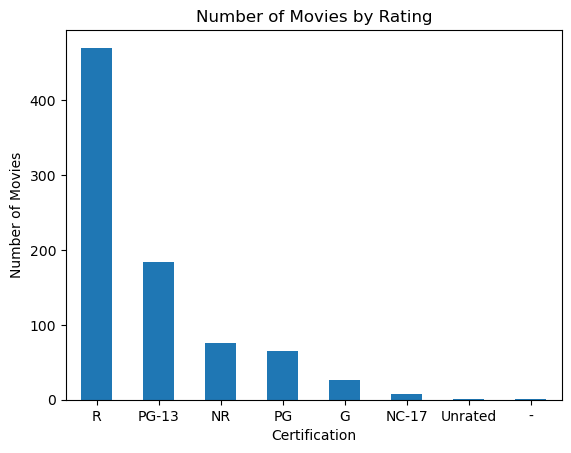

In [45]:
# get the count of each rating under 'certification' column
counts = df['certification'].value_counts()
# plot the count by certification
counts.plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel('Certification')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Rating')
plt.show();

## What is the average revenue per certification category?

In [58]:
# group data by 'certification' and calculate the revenue means of each rating 
avg = df.groupby('certification')['revenue'].mean()
# set the float format option
pd.options.display.float_format = '{:.0f}'.format
# print showing as float type
print(avg)

certification
-                0
G         66632610
NC-17         1668
NR         2144835
PG        60006795
PG-13     70670934
R         16036373
Unrated          0
Name: revenue, dtype: float64


## What is the average budget per certification category?

In [57]:
# group data by 'certification' and calculate the budget means of each rating 
b_avg = df.groupby('certification')['budget'].mean()
# print the result
print(b_avg)

certification
-                0
G         22052064
NC-17            0
NR         1409738
PG        24115342
PG-13     30623141
R          9642775
Unrated          0
Name: budget, dtype: float64


In [59]:
# Save final merged of combined 2000 and 2001 dataframes
df.to_csv(f"{FOLDER}tmdb_results_combined.csv.gz", compression="gzip",
                        index=False)